# **# 00 - set up**

In [1]:
%pip install torchio --q
%pip install monai --q
%pip install celluloid --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00
Note: you may need to restart the kernel 

In [2]:
%matplotlib notebook
    
from pathlib import Path
import nibabel as nib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from celluloid import Camera
from IPython.display import HTML

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  

set_seed(42)

## **set root paths**

In [4]:
train_path = Path("/kaggle/input/lung-cancer-segment/train/")
val_path = Path("/kaggle/input/lung-cancer-segment/val/")

(256, 256)


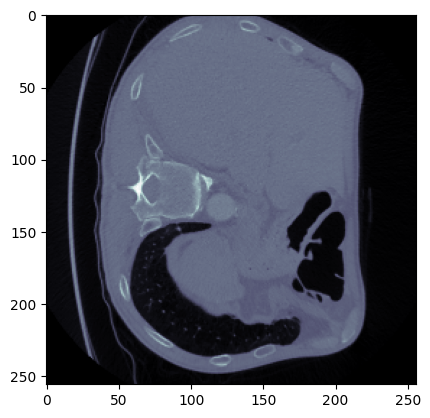

In [5]:
# understanding single slice
img = np.load(train_path/"0"/"data"/"100.npy")
print(img.shape)

fig = plt.figure()
plt.imshow(img, cmap="bone")

In [6]:
def get_sorted_slice_paths(folder: Path):
    files = sorted(folder.glob("*.npy"), key=lambda f: int(f.stem))
    if not files:
        raise ValueError(f"No .npy slices found in {folder}")
    return files

def get_patient_path(patient_id: str, train: bool) -> Path:
    if train:
        return train_path / str(patient_id)
    else:
        return val_path / str(patient_id)

def get_img_path(patient_path: Path) -> Path:
    img_path = patient_path / "data"
    if not img_path.exists():
        raise FileNotFoundError(f"Image folder not found: {img_path}")
    return img_path

def get_label_path(patient_path: Path) -> Path:
    label_path = patient_path / "masks"
    if not label_path.exists():
        raise FileNotFoundError(f"Label folder not found: {label_path}")
    return label_path

## **visualization**

In [7]:
patient_path = get_patient_path("0", True)

img_path = get_img_path(patient_path)
label_path = get_label_path(patient_path)

sorted_img_files = get_sorted_slice_paths(img_path)
sorted_mask_files = get_sorted_slice_paths(label_path)

img_volume = np.stack([np.load(f) for f in sorted_img_files], axis=-1).astype(np.float32)
mask_volume = np.stack([np.load(f) for f in sorted_mask_files], axis=-1).astype(np.uint8)

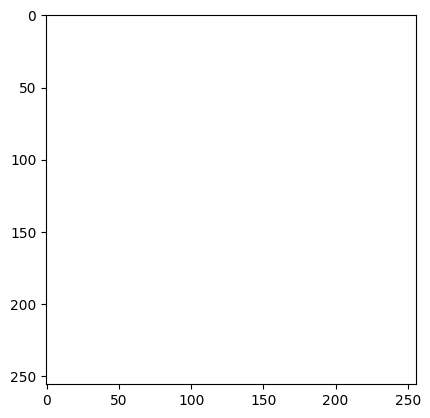

In [8]:
fig = plt.figure()
camera = Camera(fig)

for i in range(img_volume.shape[2]):
    
    plt.imshow(img_volume[:, :, i], cmap="bone")
    mask_ = np.ma.masked_where(mask_volume[:, :, i] == 0, mask_volume[:, :, i])
    plt.imshow(mask_, cmap="autumn", alpha=0.5)
    
    camera.snap();

animation = camera.animate();
HTML(animation.to_html5_video())

# **# 01 - data set**

In [9]:
from torch.utils.data import Dataset

class LungTumorDataset(Dataset):
    
    """
    Returns individual 2D slices (img, mask) from 3D CT volumes.
    """

    def __init__(self, patient_ids, train=True, transform=None):
        """
        patient_ids : list of patient identifiers (str or int)
        train       : bool, whether to use train or val dataset
        transform   : optional, function to apply data augmentation (img, mask)
        """
        self.samples = []
        self.train = train
        self.transform = transform

        # Build a list of (patient_id, slice_idx)
        for pid in patient_ids:
            patient_path = get_patient_path(pid, self.train)
            img_folder = get_img_path(patient_path)
            num_slices = len(get_sorted_slice_paths(img_folder))
            for slice_idx in range(30, num_slices): # remove first 30 slices
                self.samples.append((pid, slice_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pid, slice_idx = self.samples[idx]

        patient_path = get_patient_path(pid, self.train)
        img_folder = get_img_path(patient_path)
        mask_folder = get_label_path(patient_path)

        img_file = get_sorted_slice_paths(img_folder)[slice_idx]
        mask_file = get_sorted_slice_paths(mask_folder)[slice_idx]

        img = np.load(img_file).astype(np.float32)
        mask = np.load(mask_file).astype(np.uint8)

         # convert 2D slice to fake 3D volume (C,H,W,D)
        img_volume = torch.tensor(img).unsqueeze(0).unsqueeze(-1)   # (1,H,W,1)
        mask_volume = torch.tensor(mask).unsqueeze(0).unsqueeze(-1) # (1,H,W,1)

        if self.transform:
            # TorchIO expects a Subject
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=img_volume),
                mask=tio.LabelMap(tensor=mask_volume)
            )
            transformed = self.transform(subject)
            img_volume = transformed['image'].data
            mask_volume = transformed['mask'].data

        # squeeze back to 2D (C,H,W)
        img_tensor = img_volume.squeeze(-1)
        mask_tensor = mask_volume.squeeze(-1)

        return img_tensor, mask_tensor

## **define transforms**

In [10]:
import torchio as tio

process = tio.Compose([
    tio.ToCanonical(),               # fix orientation
    tio.RescaleIntensity((-1,1)),    # normalize intensity
    tio.CropOrPad((256,256,1))       # crop/pad HxWxD=1
])

augmentation = tio.RandomAffine(scales=(0.9,1.1), degrees=(-20,20), translation=5)

train_transform = tio.Compose([process, augmentation])
val_transform = tio.Compose([process])

In [11]:
train_ids = list(range(57))
val_ids = list(range(57, 63))

train_dataset = LungTumorDataset(train_ids, train=True, transform=train_transform)
val_dataset   = LungTumorDataset(val_ids, train=False, transform=val_transform)

print(len(val_dataset), len(train_dataset))

1155 12722


# **# 03 - model**

In [12]:
import torch.nn as nn

class DoubleConv2D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.step = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.step(x)

In [13]:
class UNet2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        # Encoder
        self.layer1 = DoubleConv2D(in_channels, 32)
        self.layer2 = DoubleConv2D(32, 64)
        self.layer3 = DoubleConv2D(64, 128)
        self.layer4 = DoubleConv2D(128, 256) 

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.layer5 = DoubleConv2D(128 + 128, 128) 

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.layer6 = DoubleConv2D(64 + 64, 64)  

        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.layer7 = DoubleConv2D(32 + 32, 32)  

        # Output
        self.layer8 = nn.Conv2d(32, out_channels, kernel_size=1)

        # Pooling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        x1 = self.layer1(x)
        x2 = self.layer2(self.maxpool(x1))
        x3 = self.layer3(self.maxpool(x2))
        x4 = self.layer4(self.maxpool(x3))

        # Decoder
        x5 = self.upconv1(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)

        x6 = self.upconv2(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)

        x7 = self.upconv3(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)

        out = self.layer8(x7)
        return out

In [14]:
model = UNet2D()

random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)
assert output.shape == random_input.shape

# **# 04 - train**

## **sampler**

In [15]:
target_list = []

for _, label in tqdm(train_dataset):
    if label.any():
        target_list.append(1)
    else:
        target_list.append(0)

  0%|          | 0/12722 [00:00<?, ?it/s]

In [16]:
from torch.utils.data import WeightedRandomSampler

target_list = np.array(target_list)

# Compute class counts
class_counts = np.bincount(target_list)   # [count_0, count_1]
class_weights = 1. / class_counts         # inverse of frequency

# Assign each sample a weight
sample_weights = [class_weights[t] for t in target_list]
sample_weights = torch.DoubleTensor(sample_weights)

# Create sampler
sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),  # you can choose fewer if you want
    replacement=True
)

## **dataloader**

In [17]:
train_loader = DataLoader(
    train_dataset, 
    sampler=sampler,
    num_workers=2, 
    batch_size=8
)

In [18]:
val_loader = DataLoader(
    val_dataset, 
    num_workers=2, 
    batch_size=8
)

In [19]:
print(len(val_loader), len(train_loader))

batch = next(iter(val_loader))
print(type(batch)) 

imgs, masks = batch
print(imgs.shape, masks.shape)

145 1591
<class 'list'>
torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


## **pytorch lightning model**

In [20]:
import pytorch_lightning as pl

class LungTumorModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = UNet2D()
        self.lr = lr
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self(imgs)
        loss = self.loss_fn(preds.float(), masks.float())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self(imgs)
        loss = self.loss_fn(preds.float(), masks.float())
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [21]:
model = LungTumorModel()

In [22]:
from pytorch_lightning.callbacks import ModelCheckpoint 

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',        
    save_top_k=1,        
    mode='min',
    filename="best_model"
)

In [23]:
from pytorch_lightning.loggers import TensorBoardLogger

trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs"),
    log_every_n_steps=10,
    callbacks=checkpoint_callback,
    max_epochs=30
)

In [24]:
trainer.fit(model, train_loader, val_loader)

2025-10-24 12:44:28.107552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761309868.361777      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761309868.435329      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# **# 05 - evaluation**

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LungTumorModel.load_from_checkpoint("/kaggle/input/checkpoints/LungTumor_BCE_CustomUNET2D.ckpt")
model.to(device);
model.freeze();
model.eval();

## **iou sensitivity specificty**

In [26]:
def compute_iou_sens_spec(preds, targets, threshold=0.5, eps=1e-6):
    """
    Compute mean IoU, sensitivity, and specificity over a batch of predictions and targets.

    Args:
        preds (torch.Tensor): Model outputs, shape [B, 1, H, W]
        targets (torch.Tensor): Ground truth masks, shape [B, 1, H, W]
        threshold (float): Binarization threshold for predictions
        eps (float): Small epsilon to prevent division by zero

    Returns:
        dict: {'iou': float, 'sensitivity': float, 'specificity': float}
    """
    # Binarize predictions
    preds = (preds > threshold).float()

    # Flatten spatial dimensions
    preds_flat = preds.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    # True positives, false positives, false negatives, true negatives
    TP = (preds_flat * targets_flat).sum(dim=1)
    FP = (preds_flat * (1 - targets_flat)).sum(dim=1)
    FN = ((1 - preds_flat) * targets_flat).sum(dim=1)
    TN = ((1 - preds_flat) * (1 - targets_flat)).sum(dim=1)

    # IoU
    iou = (TP + eps) / (TP + FP + FN + eps)

    # Sensitivity (Recall)
    sensitivity = (TP + eps) / (TP + FN + eps)

    # Specificity
    specificity = (TN + eps) / (TN + FP + eps)

    # Return mean across batch
    return {
        'iou': iou.mean().item(),
        'sensitivity': sensitivity.mean().item(),
        'specificity': specificity.mean().item()
    }

In [27]:
total_iou = 0
total_sens = 0
total_spec = 0
num_batches = 0

with torch.no_grad():
    for images, masks in tqdm(val_loader):
        
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        metrics = compute_iou_sens_spec(outputs.float(), masks.float())

        total_iou += metrics['iou']
        total_sens += metrics['sensitivity']
        total_spec += metrics['specificity']
        num_batches += 1

mean_iou = total_iou / num_batches
mean_sens = total_sens / num_batches
mean_spec = total_spec / num_batches

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Sensitivity: {mean_sens:.4f}")
print(f"Mean Specificity: {mean_spec:.4f}")


  0%|          | 0/145 [00:00<?, ?it/s]

Mean IoU: 0.8854
Mean Sensitivity: 0.9262
Mean Specificity: 0.9999


## **result visualization**

In [28]:
patient_path = get_patient_path("57", False)
img_path = get_img_path(patient_path)
label_path = get_label_path(patient_path)

sorted_img_files = get_sorted_slice_paths(img_path)
sorted_mask_files = get_sorted_slice_paths(label_path)

img_volume = np.stack([np.load(f) for f in sorted_img_files], axis=-1).astype(np.float32)  # (H, W, D)
mask_volume = np.stack([np.load(f) for f in sorted_mask_files], axis=-1).astype(np.float32)

# --------------------------
# Wrap in TorchIO Subject
# --------------------------
subject = tio.Subject(
    image=tio.ScalarImage(tensor=torch.from_numpy(img_volume).unsqueeze(0)),  # (1, H, W, D)
    mask=tio.LabelMap(tensor=torch.from_numpy(mask_volume).unsqueeze(0))
)

# --------------------------
# Apply validation transform
# --------------------------
val_transform = tio.Compose([
    tio.ToCanonical(),
    tio.RescaleIntensity((-1, 1)),
])


subject = val_transform(subject)
img_volume = subject.image.data      # shape (1, 256, 256, D)
mask_volume = subject.mask.data      # shape (1, 256, 256, D)

# --------------------------
# Reorder for model: (D, 1, H, W)
# --------------------------
img_volume = img_volume.permute(3, 0, 1, 2).contiguous()  # (D, 1, H, W)
mask_volume = mask_volume.permute(3, 0, 1, 2).contiguous()

img_volume = img_volume.to(device)
mask_volume = mask_volume.to(device)

print("Prepared volume shape:", img_volume.shape)

Prepared volume shape: torch.Size([274, 1, 256, 256])


In [29]:
chunk_size = 50
preds_list = []

# Iterate over the depth dimension (0th axis)
for start in range(0, img_volume.shape[0], chunk_size):
    end = min(start + chunk_size, img_volume.shape[0])
    
    # Slice depth chunk → shape [chunk, 1, H, W]
    chunk = img_volume[start:end]  
    
    # Move to device
    chunk = chunk.to(device).float()
    
    with torch.no_grad():
        preds_chunk = torch.sigmoid(model(chunk))  # [chunk, 1, H, W]
    
    preds_list.append(preds_chunk.cpu())  # move to CPU immediately

# Concatenate predictions along depth axis
preds = torch.cat(preds_list, dim=0)  # shape: [D, 1, H, W]

# Binarize
preds_bin = (preds > 0.5).float()

print("Unique values in preds_bin:", torch.unique(preds_bin))

# Rearrange to (H, W, D)
pred_mask = preds_bin.permute(2, 3, 0, 1).squeeze(-1)  # (H, W, D)

# Move image to same shape for visualization
img_volume_np = img_volume.permute(2, 3, 0, 1).squeeze(-1).squeeze(1).cpu().numpy()
mask_np = mask_volume.squeeze(1).permute(1, 2, 0).cpu().numpy()
pred_mask_np = pred_mask.cpu().numpy() 

print("Shapes:")
print("img_volume:", img_volume_np.shape)
print("mask_volume:", mask_np.shape)
print("pred_mask:", pred_mask_np.shape)

Unique values in preds_bin: tensor([0., 1.])
Shapes:
img_volume: (256, 256, 274)
mask_volume: (256, 256, 274)
pred_mask: (256, 256, 274)


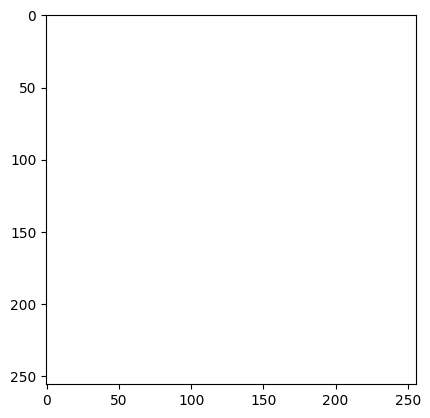

In [30]:
fig = plt.figure()
camera = Camera(fig)

for i in range(img_volume_np.shape[2]):
    
    plt.imshow(img_volume_np[:, :, i], cmap="bone")
    
    mask_ = np.ma.masked_where(mask_np[:, :, i] == 0, mask_np[:, :, i])
    plt.imshow(mask_, cmap="autumn", alpha=0.5)
    
    pred_ = np.ma.masked_where(pred_mask_np[:, :, i] == 0, pred_mask_np[:, :, i])
    plt.imshow(pred_, cmap="winter", alpha=0.5)
    
    camera.snap()

animation = camera.animate();
HTML(animation.to_html5_video())